# Classification

---

*You can watch a [video](https://youtu.be/71GtdWmznok) of this lesson if you prefer.*

---


## Table of Contents

- [Introduction](#Introduction)
- [Binary Classification](#Binary-Classification)
	- [Sigmoid Activation](#Sigmoid-Activation)
	- [Negative Log Likelihood](#Negative-Log-Likelihood)
	- [Training Loop - Binary Classification](#Training-Loop---Binary-Classification)
- [Classification With Multiple Targets](#Classification-With-Multiple-Targets)
	- [The Softmax Function](#The-Softmax-Function)
	- [Negative Log Likelihood, Extended](#Negative-Log-Likelihood,-Extended)
	- [Multiclass Loss Gradient](#Multiclass-Loss-Gradient)
	- [Training Loop - Multiple Classes](#Training-Loop---Multiple-Classes)
- [Wrap-up](#Wrap-up)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sympy import diff, symbols, ln, simplify, exp, expand

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('..')
from nnets.dense import Dense
from data.csv_data import SkyServerBinaryDatasetWrapper, SkyServerDatasetWrapper

## Introduction

In the [last lesson](../3-Dense_Networks/dense.ipynb), we trained our neural network on a regression task.<br>
The network predicted a number, `tmax_tomorrow`, that can take on a positive or negative value.<br>

> Linear regression is a specific type of regression that focuses on the linear relationship between *one* predictor and *one* outcome.<br>
> Regression more generally examines how several predictors relate to an outcome variable. So, our model does the latter, by assembling many of the first.

The great thing about neural network is the structural plasticity. If we want, we can change activations and loss functions to adapt to different tasks.<br>
For example, we can also train our model on a classification task.

> In a classification task, we want the network to predict which category something belongs to.

In this lesson, we're going to predict if an object detected by a telescope is a `star`, a `galaxy`, or a `quasar`.

<div style="text-align: center;">
    <img src="../images/classification/classification.png" alt="Classification">
</div>

Other than regression, classification lets us output the probability that an example belongs to one of many classes (`star`, `galaxy`, or `quasar`).<br>
In classification, most of the neural network works the same - the two main things that change are the activation function and the loss function.

Don't get me wrong, it is possible to use a regression model for classification, but it's not the best way to do it.<br>
This is because the output of a regression model is continuous, and we need a discrete output for classification.<br>
So, while in theory we could associate a particular range of values with each class, we would introduce a lot of need for interpretation.<br>
For example, if we'd be able to predict that a `star` is between $0.00$ and $0.33$, a `galaxy` is between $0.34$ and $0.66$, and a `quasar` is between<br>
$0.67$ and $1.00$, we would still need to decide what to do with the values that fall between and outside these ranges.

## Binary Classification

For a start, we'll train a network to perform **binary classification**.<br>
In binary classification, our target is either a $0$, or a $1$. 

In binary classification, we can only have two classes.<br>
In our example, these are `star` and `not star`.

- $0$ means that there is a $0\%$ chance of the item belonging to the category, and
- $1$ means that there is a $100\%$ chance of the item belonging to the category.

Our network will return something close to $1$ if it thinks the telescope detected a star, and close to $0$, otherwise.

Let's load in our data:

In [2]:
# Append the path so we can import the correct library
sys.path.append(os.path.abspath("../data"))

# Load in our data.  The wrapper handles the details of loading and processing the data for us.
wrapper = SkyServerBinaryDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [3]:
print(type(train_x), "\n")
print(train_x.shape, "\n")
print(train_x[:5])

<class 'numpy.ndarray'> 

(7000, 13) 

[[ 0.16745842 -0.58492272  1.03148637 -0.34855938 -0.83728027 -0.94605772
  -0.99534154 -0.83806089  0.21085172 -0.21763043 -0.36973112  1.03148936
   1.30931064]
 [ 0.16886159 -0.58311429  0.05243046 -0.16653251 -0.15415531 -0.08264457
  -0.02604308 -0.83806089  0.21085172 -0.21763043 -0.36984929 -0.63621258
  -0.87919741]
 [ 0.17057433 -0.58347525  0.92156796  0.86709322  0.59315368  0.44120145
   0.31452753 -0.83806089  0.21085172 -0.21147922 -0.05302706 -0.65633905
  -0.60919097]
 [ 0.17455754 -0.58650069 -1.03063038 -0.81362749 -0.63669227 -0.52660429
  -0.43092107 -0.83806089  0.21085172 -0.20532801 -0.36999261  1.03148936
   1.30931064]
 [ 0.17482457 -0.58441247 -1.29023238 -1.17251944 -0.37676237 -0.02510121
   0.15827647 -0.83806089  0.21085172 -0.20532801 -0.36818949  1.03148936
   1.30931064]]


We retreived a set of training inputs `train_x`. Each row has $13$ input variables for our network.<br>
We'll use all these $13$ variables to predict a single target variable, the level of certainty that the object is a star:

In [4]:
print(type(train_y), "\n")
print(train_y.shape, "\n")
print(train_y[:5])

<class 'numpy.ndarray'> 

(7000, 1) 

[[0]
 [0]
 [1]
 [0]
 [0]]


As you can see above, the target is $0$ when the object is `not a star`, and $1$ if it truly is a `star`.<br>
We want our network to output a number between `0` and `1` indicating the probability that the object is a `star`.

Let's learn how to set our network up to do this.

### Sigmoid Activation

In the [previous lesson](../3-Dense_Networks/dense.ipynb), we didn't apply an activation function to the output of our network - we just output the last layer directly.<br>
In a binary classification problem, we want to predict only within a range $[0;1]$.<br>
A neural network can output values outside this range, so we need to constrain the outputs.

We can do this using the sigmoid activation function.<br>
Mathematically, the sigmoid function is $\sigma=\frac{1}{1 + e^{-x}}$.<br>
$e$ is a special number, Euler's constant, with a value around `2.71`; For $e$ it is defined that $ln(e)=1$.

Raising the number $e$ to the power $-x$ will result in a number close to $0$ when $x$ is high.<br>
This is because a negative exponent is the product of fractions, like $3 ^ {-2}$ is equal to $1/3 * 1/3$.<br>
When $x$ is large, sigmoid will output a number very close to $1$, because $e^{-x}$ will be close to $0$, and the denominator will be close to $1$.

Raising the number $e$ to the power $-x$ when $x$ is a negative number will make the value of $e^{-x}$ very large.<br>
The negative sign in $e^{-x}$ will undo the negative sign on $x$, so we'll raise $e$ to a large positive power.<br>
This will make the denominator very large, and push the sigmoid close to $0$.

You can see the graph of the sigmoid function below:

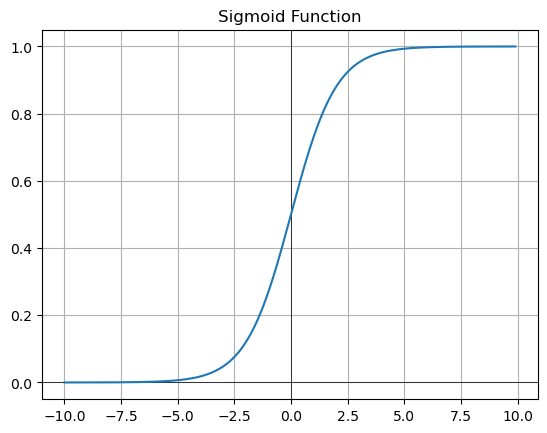

In [5]:
nn_outputs = np.arange(-10, 10, .1)
sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.title('Sigmoid Function')
plt.axhline(0, color='black', lw=.5)
plt.axvline(0, color='black', lw=.5)
plt.grid(True)
plt.plot(nn_outputs, sigmoid(nn_outputs));

Our network will be enabled to output continuous real numbers in the last layer (one number per input that is),<br>
and the sigmoid function will transform these 'descriptions' into probabilities from $0$ to $1$, ultimately<br>
describing the probability of the input belonging/not belonging to a given class.

For example, if we code a star as $1$, and everything else as a $0$, the output of the sigmoid activation tells us<br>
the probability that an example is a star. The sigmoid output might be $.51$, corresponding to a $51\%$ probability.

### Negative Log Likelihood

Because the range of values after we apply the sigmoid function is so compact, Mean Squared Error, which works through<br>
amplifying differences in magnitude, isn't the best loss function here.<br>
If the actual target is a $1$, and we predict a $.5$, squared error will only be $.25$.

Here's what mean squared error looks like with binary classification:

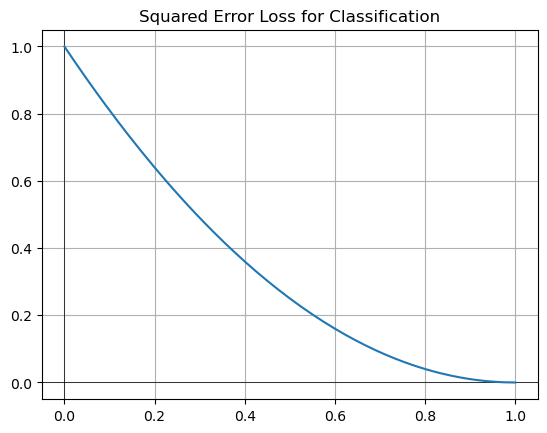

In [6]:
se = lambda pred, actual: (actual - pred) ** 2
output_probs = sigmoid(nn_outputs)

plt.title('Squared Error Loss for Classification')
plt.axhline(0, color='black', lw=.5)
plt.axvline(0, color='black', lw=.5)
plt.grid(True)
plt.plot(output_probs, se(output_probs, 1));

The squared error (and therefore mean squared error) only ranges between $0$ and $1$.<br>
While this can work still, it makes it hard for the network penalty to be sizable enough to provoke a meaningful parameter update to penalize incorrect guesses.<br>
We instead want a function that will penalize incorrect predictions much more than predictions that are close to the actual value.

To generate loss measures that provoke meaningful updates, instead, we use the negative log likelihood.<br>
It is defined as:
$$NLL = -(y * log(\hat{y}) + (1-y) * log(1-\hat{y}))$$

Since $y$ is always $0$ or $1$, one half of the equation will always be switched off, i.e. $0$.<br>
Let's say $y$ is $1$, and $\hat{y}$ is $.7$.

$$NLL = -(1 * log(.7) + (1-1) * (1-.7))$$
$$NLL = -(1 * log(.7) + 0 * (1-.7))$$
$$NLL = -(1 * log(.7))$$
$$NLL = -(1 * log(.7))$$
$$NLL = \underline{\underline{.3566}}$$

Remember that $log(.7)$ means "to what power do I need to raise $e$ to get $.7$?"<br>
To get a number between $0$ and  $1$ (which is what the sigmoid function outputs),<br>
you have to raise $e$ to a negative power.<br>
Raising to a negative power is the same as repeatedly multiplying $1/e$ by itself.<br>
The closer $\hat{y}$ is to $1$, the lower the negative power (the further from $0$).

You then "undo" the negative with the beginning negative sign for negative log likelihood.<br>
Note that $log(0)$ itself is $\text{undefined}$, so we have to be careful not to pass $0$ in as our prediction.<br>
Luckily, the sigmoid function can't actually output total $0$, since sigmoid is $\frac{1}{(1+e^{-x})}$.<br>
As $e^{-x}$ increases, the sigmoid outputs numbers closer and closer to $0$, but never reaches $0$.<br>
(That is at least in theory, computers can confuse really large and really small inputs with total zeros and mess up the party, but inputs of large scale are simply to be avoided.)

We're assuming that the correct target is $1$.<br>
Let's see how negative log likelihood changes as we change our predictions:

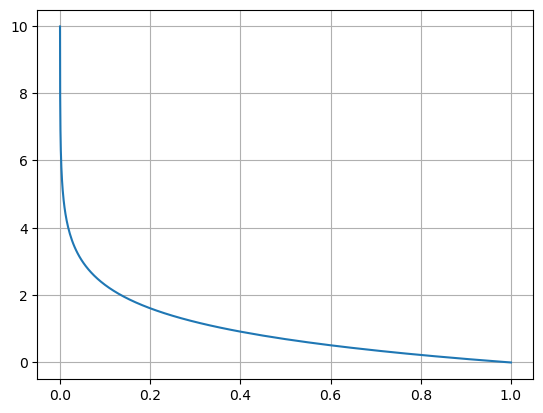

In [7]:
# Define negative log likelihood function
tol = 1e-6 # Add a small tolerance to avoid taking a log close to 0
nll = lambda pred, actual: -(actual * np.log(pred + tol) + (1-actual) * np.log((1-pred + tol)))

correct_prob = 1 # 1 means correct class is predicted

# Plot negative log likelihood against our simulated output probabilities
plt.grid(True)
plt.plot(output_probs, nll(output_probs, correct_prob));

We can see that negative log likelihood gets very large as our prediction gets closer to $0$.<br>
This loss function will penalize big errors in predictions more than mean squared error.

### Training Loop - Binary Classification

We now know enough to try binary classification using our neural network.<br>
We'll run the network normally, but apply the sigmoid function to the output layer, then measure error with negative log likelihood.<br>
In the [last lesson](../3-Dense_Networks/dense.ipynb), we trained a neural network to make predictions.<br>
We'll use the same code as last time, but this time we'll define our neural network using a class.<br>
This helps us avoid rewriting all of the same code from last time again.

We'll define a neural network with $2$ layers.<br>
Layer $1$ will take in $13$ input features, and convert them into $25$ hidden features.<br>
Layer 2 will take those $25$ hidden features, and turn them into a single, sigmoid-activated output.

Let's see how this works:

In [8]:
class ClassificationNet():
    def __init__(self, output_size=1):
        # Setup 2 neural network layers.  Each Dense class is a single network layer.
        # We don't use relu activation on the second layer, but we do in the first layer.
        self.layer1 = Dense(input_size=13, output_size=25)
        self.layer2 = Dense(input_size=25, output_size=output_size, activation=False)

    def forward(self, x):
        # In the forward pass, we take in input data, and run our 2 layers over the data.
        x = self.layer1.forward(x)
        x = self.layer2.forward(x)
        return x

    def backward(self, grad, lr):
        # In the backward pass, we take the gradient and learning rate, and use them to adjust parameters in each layer.
        grad = self.layer2.backward(grad, lr)
        self.layer1.backward(grad, lr)

The forward and backward pass will mostly work the same way they did in the [last lesson](../3-Dense_Networks/dense.ipynb).<br>
The main difference is in how we calculate the gradient of the loss function and backpropagate it across, due to the sigmoid activation.

You can see how this will look here:
<div style="text-align:center;">
    <img src="../images/classification/forward_backward.svg" alt="Forward-Backward">
</div>

Our network will output a single number in the last layer - let's call this $z$.<br>
We run the sigmoid function over $z$ to get the output probability $p$.<br>
Then, we use loss function $L$ (negative log likelihood) to calculate how far we were from the actual target.

The derivative of the loss function $L$ with respect to the predicted probabilities $p$ is $\frac{\partial L}{\partial p}=\frac{p-y}{p(1-p)}$.<br>
The derivative across the sigmoid function of the probabilities $p$ with respect to the network output $z$ is $\frac{\partial p}{\partial z}=p(1-p)$.<br>
If we want to compute the partial derivative of the loss $L$ with respect to the neural network output $z$, we multiply the two by the chain rule:

$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial p} * \frac{\partial p}{\partial z}$$
$$\frac{\partial L}{\partial z} = \frac{p-y}{p(1-p)} * \frac{\partial p}{\partial z}=p(1-p)$$
$$\frac{\partial L}{\partial z} = p - y$$

We're literally just left with $p-y$, i.e. the predicted probabilities $p$ minus the target $y$.<br>
So in one step, we'll calculate the gradient with respect to the output of our neural network.

We can verify this using `sympy`.<br>
First, we take the derivative of negative log likelihood:

In [9]:
actual, pred = symbols('y, p')                             # Define symbols for our equation
sympy_nll = -(actual * ln(pred) + (1-actual) * ln(1-pred)) # Define nll using sympy
simplify(diff(sympy_nll, pred))                            # Take the derivative of nll with respect to p (predictions) with diff, then simplify

(-p + y)/(p*(p - 1))

The above gives us $\frac{\partial L}{\partial p}$, which is a rephrased $\frac{p-y}{p(1-p)}$.<br>
We now need $\frac{\partial p}{\partial z}$:

In [10]:
x = symbols('x')                    # Define an x symbol
sympy_sigmoid = (1 / (1 + exp(-x))) # Define sigmoid using sympy
diff(sympy_sigmoid, x)              # Take the partial derivative

exp(-x)/(1 + exp(-x))**2

The above is equal to $\sigma(1-\sigma)$, or $p(1-p)$ (the output of the sigmoid function).<br>
We can now write our `nll_grad` function:

In [11]:
# Computes the gradient with respect to the outputs of the neural network
# Input will be the sigmoid function applied to the neural network outputs
nll_grad = lambda pred, actual: pred - actual

We can see that this gives us a clear gradient that we can follow with gradient descent:

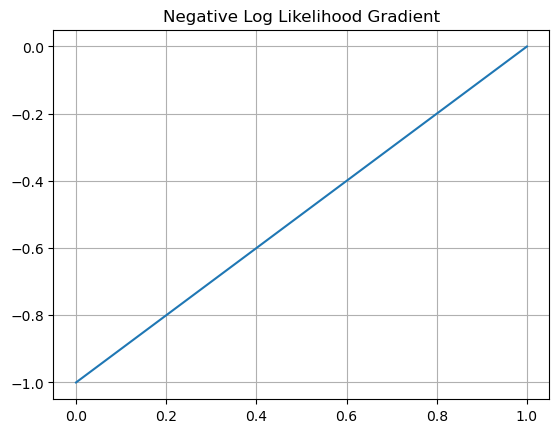

In [12]:
plt.title('Negative Log Likelihood Gradient')
plt.grid(True)
plt.plot(output_probs, nll_grad(output_probs, 1));

We can now write the training loop using sigmoid activation and negative log likelihood:

In [13]:
net = ClassificationNet(1)
lr = 1e-2
epochs = 50

for epoch in range(epochs):
    epoch_loss = 0
    for x, target in zip(train_x, train_y):
        # Run the sigmoid function over the output of the neural network
        pred = sigmoid(net.forward(x.reshape(1,-1)))

        # Compute the gradient using the nll_grad function
        grad = nll_grad(pred, target)
        epoch_loss += nll(pred, target)[0,0]

        # Update the network parameters
        net.backward(grad, lr)

    if epoch % 10 == 0 or epoch == epochs - 1:
        valid_loss = 0
        for x, target in zip(valid_x, valid_y):
            pred = sigmoid(net.forward(x.reshape(1,-1)))
            valid_loss += nll(pred, target)[0,0]
        print(f"Epoch {epoch+1} Train loss: {epoch_loss / len(train_x):.5f}\t Validation loss: {valid_loss / len(valid_x):.5f}")

Epoch 1 Train loss: 0.26827	 Validation loss: 0.26448
Epoch 11 Train loss: 0.10105	 Validation loss: 0.12040
Epoch 21 Train loss: 0.07649	 Validation loss: 0.09313
Epoch 31 Train loss: 0.06805	 Validation loss: 0.09299
Epoch 41 Train loss: 0.06248	 Validation loss: 0.09788
Epoch 50 Train loss: 0.05948	 Validation loss: 0.11983


We were able to reduce the loss from epoch to epoch and distinguish the data fairly well by the end of training.

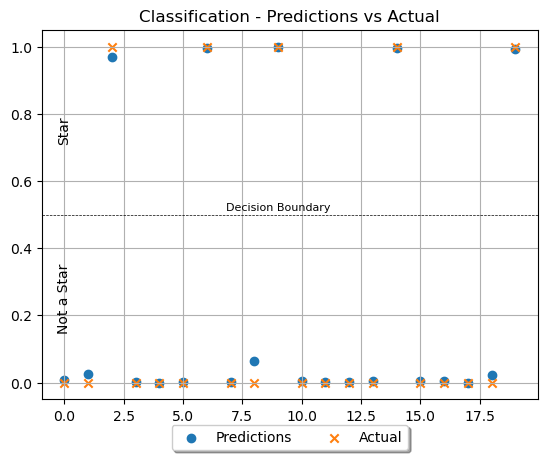

In [14]:
ex_depth = 20
x_display = train_x[:ex_depth]
y_display = train_y[:ex_depth]
y_produce = sigmoid(net.forward(x_display)).flatten()

plt.title('Classification - Predictions vs Actual')
plt.axhline(.5, color='black', lw=.5, ls='--')
plt.scatter(range(len(y_produce)), y_produce, label='Predictions')
plt.scatter(range(len(y_display)), y_display, label='Actual', marker='x')
plt.text(9, 0.52, 'Decision Boundary', fontsize=8, rotation=0, va='center', ha='center')
plt.text(0, 0.25, 'Not a Star', fontsize=10, rotation=90, va='center', ha='center')
plt.text(0, 0.75, 'Star', fontsize=10, rotation=90, va='center', ha='center')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2);

## Classification With Multiple Targets

Now that we've covered *binary classification*, let's expand this notion to the **classification with multiple targets**.<br>
Let's say that our telescope can identify $3$ different kinds of objects, and we want to know the probability that it has detected each one.<br>
These $3$ objects are `stars`, `galaxies`, and `quasars`.

Think of multi-class classification as multiple binary classification problems.<br>
(Class 1 vs. Not Class 1, latter contains Class 2 vs. Not Class 2, etc.)

Our first step is to encode our targets into one-hot vectors. Each position in the vector will correspond to a single class.<br>
We'll say that a star corresponds to a $1$ in position $0$, a galaxy to a $1$ in position $1$, and a quasar to a $1$ in position $2$:

In [15]:
def encode(target, max_value=3):
    encoded = np.zeros((1,max_value))
    encoded[0,target] = 1
    return encoded

In [16]:
print(encode(0))    # Encode a star
print(encode(1))    # Encode a galaxy
print(encode(2))    # Encode a quasar

[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


As you can see above, we end up with a $3$-element vector after encoding.<br>
The position in the vector that is $1$ corresponds to our class label<br>
(`star`, `galaxy`, or `quasar`). This is why it is called one-hot encoding - **only one position in the vector is non-zero**.

We'll use our network to predict this vector by outputting $3$ numbers.<br>
Similar to what we did with the sigmoid function, we need a way for the network<br>
to output values between $0$ and $1$ for each position in the vector.

**But,** we also need all of the elements in the output vector to add up to $1$.<br>
Each vector element is the probability that the item belongs to that class.<br>
Our total probability to be *distributed across* these possibilities has add up to $100\%$.

How can we do this?

### The Softmax Function

The softmax function will normalize the values from our output vector and express them as part of a probability distribution.<br>

$$\zeta=\frac{e^{\hat{y_{i}}}}{\sum_{j=0}e^{\hat{y_{j}}}}$$

To make notation worse, the softmax and sigmoid functions usually use the same symbol $\sigma$.<br>
To eliminate that confusion, we'll use $\zeta$ for softmax.<br>
Intuitively, softmax will raise the current prediction to the power $e^{y_{i}}$, then<br>
divide by the sum of all the other predictions. Larger predictions will get pushed closer to $1$,<br>
and smaller predictions will get pushed closer to $0$.<br>
This is why it is called a softmax - it is a "softer"/more considerate way of marking the maximum of a vector.

Let's take a look at the function:

In [17]:
def softmax(preds):
    preds = np.exp(preds) # e^(predictions)
    # Divide the predictions by the sum
    if len(preds.shape) > 1:
        # Handle matrix input
        normed = preds / np.sum(preds, axis=1).reshape(-1,1)
    else:
        # Handle vector input
        normed = preds / np.sum(preds)
    return normed

In [18]:
print(softmax(np.array([10,20,30])))

[2.06106005e-09 4.53978686e-05 9.99954600e-01]


As you can see above, softmax pushed $30$ very close to $1$ in the output vector,<br>
and it also pushed the other $2$ values close to $0$.

We can also plot this out to see how our $x$ values change as we softmax them:

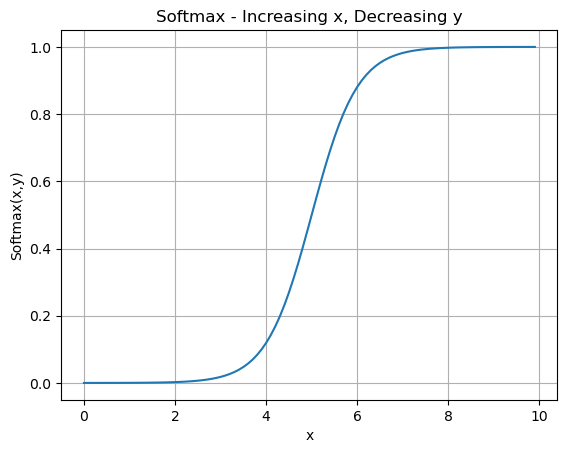

In [19]:
x = np.arange(0,10,.1).reshape(-1,1)  # 0 to 10
y = np.arange(10,0,-.1).reshape(-1,1) # 10 to 0

# As x increases and y decreases, the first class (x) becomes more likely
# Likelihood of x class increases in softmax shape
plt.xlabel('x')
plt.ylabel('Softmax(x,y)')
plt.title('Softmax - Increasing x, Decreasing y')
plt.grid(True)
plt.plot(x, softmax(np.hstack((x,y)))[:,0]);

### Negative Log Likelihood, Extended

Our earlier negative log likelihood formula $NLL = -(y * log(\hat{y}) + (1-y) * log(1-\hat{y}))$<br>
only worked for binary classification. We'll extend it to work with multiple classes, and specifically a vector of probabilities:

$$NLL = - \sum_{i=0} y_{i} \log p_{i}$$

We look at each position in the encoded vector, and multiply it by the log of the prediction at that position.<br>
We then add up all of these values to get the log loss.

Similar to the binary negative log likelihood, the multiclass case will only be non-zero at a single position in the vector.<br>
So we're essentially looking at the position where actual equals $1$ times the log of the prediction at that position.<br>
If the prediction is close to $0$ at that position, then $log(p)$ will become a large negative number.<br>
If the prediction is close to $1$, then $log(p)$ will get close to $0$.<br>
Since we have a negative sign at the beginning of the log loss formula,<br>
this will mean that log loss gets higher if the prediction is further away from the actual value.

This is essentially the same as binary negative log likelihood.<br>
In the binary case, we had to "correct" for the fact that we only had one probability number.<br>
But imagine we had two numbers - one indicating the percentage the observation was a star,<br>
and one indicating that it was not.

Both numbers would add to $1$, so $NLL = -(y * log(\hat{y}) + (1-y) * log(1-\hat{y}))$ (with one output)<br>
would be equivalent to $NLL = - \sum_{i=0} y_{i} \log p_{i}$ (with $2$ outputs).

Let's take a look at how this works:

In [20]:
def multiclass_loss(predicted, actual, print_ce=False):
    # We add a small tolerance to avoid taking the log of 0, which is undefined
    tol = 1e-6
    cross_entropy = actual * np.log(predicted + tol)
    if print_ce:
        print(cross_entropy)
    return -np.sum(cross_entropy)

In [21]:
# An example where the prediction is close to the actual value - loss is low
multiclass_loss(np.array([.8, .1, .1]), np.array([1,0,0]), True)

[-0.2231423 -0.        -0.       ]


0.2231423013149909

In [22]:
# An example where the prediction is far from the actual value - loss is high
multiclass_loss(np.array([0, .2, .8]), np.array([1,0,0]), True)

[-13.81551056  -0.          -0.        ]


13.815510557964274

As you can see above, `actual * np.log(predicted)` is zero at all positions except the position where `actual` equals $1$.<br>
As the difference between predicted and actual at that position increases, log loss increases.

### Multiclass Loss Gradient

To find the gradient of $\frac{\partial L}{\partial z}$, we again need to find $\frac{\partial L}{\partial p} * \frac{\partial p}{\partial z}$.<br>
To find $\frac{\partial L}{\partial p}$ we need to take the derivative of the log loss equation, and multiply by the derivative of the softmax equation.<br>
Similarly to the sigmoid and binary negative log likelihood, the activation and loss largely cancel out,<br>
and we end up with the following gradient, which is just $p-y$:

In [23]:
log_loss_grad = lambda pred, actual: pred - actual

### Training Loop - Multiple Classes

We're now ready to write our training loop with multiple classes.

The main differences are:
- $3$ outputs instead of $1$
- `softmax` to generate our probabilities instead of `sigmoid`
- `multiclass_loss` to find our error
- we'll encode our target into a one-hot vector before measuring loss

In [24]:
# Load the data with 3 target values instead of the binary value from earlier
wrapper = SkyServerDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [25]:
# Setup our network with 3 outputs
net = ClassificationNet(3)
lr = 1e-3
epochs = 50

for epoch in range(epochs):
    epoch_loss = 0
    for x, target in zip(train_x, train_y):
        # Run the softmax function over the output of the neural network
        pred = softmax(net.forward(x.reshape(1,-1)))

        encoded = encode(target)
        # Compute the gradient using the nll_grad function
        grad = log_loss_grad(pred, encoded)
        epoch_loss += multiclass_loss(pred, encoded)

        # Update the network parameters
        net.backward(grad, lr)

    if epoch % 10 == 0 or epoch == epochs - 1:
        valid_loss = 0
        for x, target in zip(valid_x, valid_y):
            pred = softmax(net.forward(x.reshape(1,-1)))
            encoded = encode(target)
            valid_loss += multiclass_loss(pred, encoded)   
        print(f"Epoch {epoch+1} Train loss: {epoch_loss / len(train_x):.5f}\t Validation loss: {valid_loss / len(valid_x):.5f}")     

Epoch 1 Train loss: 0.53404	 Validation loss: 0.36925
Epoch 11 Train loss: 0.17076	 Validation loss: 0.20608
Epoch 21 Train loss: 0.12945	 Validation loss: 0.16617
Epoch 31 Train loss: 0.10978	 Validation loss: 0.14806
Epoch 41 Train loss: 0.09654	 Validation loss: 0.13614
Epoch 50 Train loss: 0.08663	 Validation loss: 0.12601


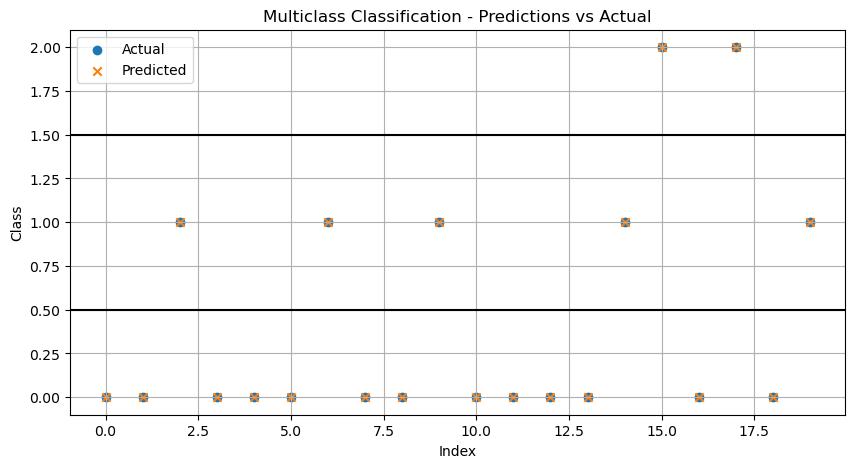

In [26]:
ex_depth = 20
x_display = train_x[:ex_depth]
y_display = train_y[:ex_depth]
preds = []

for x, target in zip(x_display, y_display):
    preds.append(softmax(net.forward(x.reshape(1,-1))))

preds = np.argmax(np.array(preds), axis=2)

plt.figure(figsize=(10, 5))
plt.scatter(range(ex_depth), y_display, label='Actual', marker='o')
plt.scatter(range(ex_depth), preds, label='Predicted', marker='x')
plt.title('Multiclass Classification - Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Class')

plt.axhline(0.5, color='black', lw=1.5)
plt.axhline(1.5, color='black', lw=1.5)

plt.legend()
plt.grid(True);

As we can see above, the network reduces training and validation loss over successive epochs.

## Wrap-up

We learned a lot in this lesson!  You should now have a good idea of how to train a neural network<br>
to do classification - both binary and with multiple targets.

In the next lesson, we'll cover recurrent neural networks, a type of neural network that works on sequences of data.